In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [ ]:
transform = transforms.ToTensor()

trainset = datasets.MNIST('./MNIST_data/', download = True, train = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)

valset = datasets.MNIST('./MNIST_data/', download = True, train = False, transform = transform)
valloader = torch.utils.data.DataLoader(valset, batch_size = 64, shuffle = True)


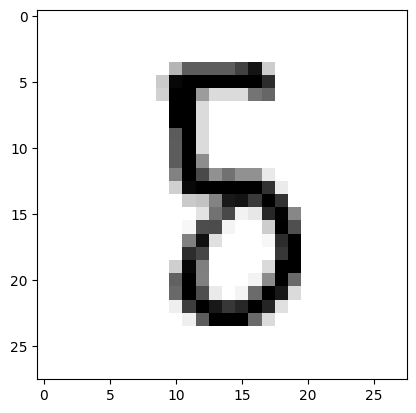

In [ ]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [ ]:
print(imagens[0].shape) #verifica as dimensões do tensor da imagem
print(etiquetas[0].shape)

torch.Size([1, 28, 28])
torch.Size([])


In [ ]:
class Modelo(nn.Module):
  def __init__(self):
    super(Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128) #Camada de entrada, 784 neurônios que se ligam a 128
    self.linear2 = nn.Linear(128, 64) # camada interna 1, 128 neurônios se ligam a 64
    self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neurônios se ligam a 10
    # não é necessario usar uma camada para a saida, pois é só pegar a saida da camada interna 2

  def forward(self, X):
    X = F.relu(self.linear1(X)) # função de ativação da camada de entrada para a camada interna 1
    X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para a camada interna 2
    X = self.linear3(X) # função de ativção da camada interna 2 para a camada de saida, nesse caso f(x) = x
    return F.log_softmax(X, dim=1) # dados utilizados para calcular a perda


In [ ]:
def treino(modelo, trainloader, device):
  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) #atualização dos pesos e da bias
  inicio = time() # time para saber o tempo de treinamento

  criterio = nn.NLLLoss() # defininifo o criterio para calcular a perda
  EPOCHS = 10 #numero de epochs que o algoritmo rodará
  modelo.train() #ativa o modo de treinamento

  for epoch in range(EPOCHS):
    perda_acumulada = 0 #inicia a perda acumulada de cada epoch

    for imagens, etiquetas in trainloader:

      imagens = imagens.view(imagens.shape[0], -1) # converte a imagens para vetores 28*28 casas
      otimizador.zero_grad() #gera o gradiente por conta do ciclo anterior

      output = modelo(imagens.to(device)) # coloca os dados no modelo
      perda_instantanea = criterio(output, etiquetas.to(device)) #calcula a perda da epoch em questão

      perda_instantanea.backward() # back propagation a partir da perda

      otimizador.step() #utiliza od pesos e as bias

      perda_acumulada += perda_instantanea.item() #atualização da perda acumulada

    else:
      print("Epoch {} - perda resultante: {}".format(epoch+1), perda_acumulada/len(trainloader))

  print("\Tempo de treino (em minutos): ", (time()-inicio)/60)


In [ ]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0

  for imagens, etiquetas in valloader:

    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)

      #desativa o upgrade e acelega a validação
      with torch.no_grad():
        logps = modelo(img.to(device)) #output do modelo em escala logaritmica


      ps = torch.exp(logps) #converte o output para escala normal
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab))
      etiqueta_certa = etiquetas.numpy()[i]

      if (etiqueta_certa == etiqueta_pred):
        conta_corretas += 1
      conta_todas += 1

  print("Total de imagens testadas: ", conta_todas)
  print("Precisao do modelo: ", (conta_corretas*100/conta_todas))


In [ ]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)